# 3.6 손글씨 숫자 인식

## 3.6.1 MNIST 데이터셋


밑바닥부터 시작하는 딥러닝 책 기준 p. 96에 해당하는 내용입니다.

In [1]:
import pickle, gzip, numpy, urllib.request, json, os

# url_base : mnist 데이터가 있는 기본 url
url_base = 'http://yann.lecun.com/exdb/mnist/'

# mnist 데이터를 저장하고 싶은 위치, 원하는 위치로 지정하면 됨.
save_folder = '/content/mnist/'

# mnist의 기본 url에서 추가적으로 붙여줘야 하는 파일명들
# train-images-idx3-ubyte.gz : training image
# train-labels-idx1-ubyte.gz : training label
# t10k-images-idx3-ubyte.gz : test image
# t10k-labels-idx1-ubyte.gz : test label
key_file = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']


# urlretrieve : 첫 번째 인자: url 위치, 두 번째 인자: the file location to copy to
# training image, training label, test image, test label을 다운받아보자.
for file_name in key_file:
    urllib.request.urlretrieve(os.path.join(url_base, file_name), os.path.join(save_folder, file_name))



다음과 같이 mnist 데이터가 받아진 것을 확인하실 수 있습니다.



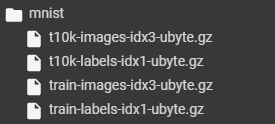

In [3]:
import numpy as np

# 받은 .gz 파일들을 오픈해보자.
# np.frombuffer가 아닌, f.read()로만 받게 되면 bytes 데이터가 되며, 이렇게 된 경우 우리가 쓸 수 없다.
# 따라서, 이를 numpy array로 바꿔주는 것이 바로 np.frombuffer이다.
# 참고자료: https://d-tail.tistory.com/32
# offset은 어디부터 데이터를 읽을지를 나타내는데, mnist 데이터 설명에 따르면
# Image의 경우, offset을 16으로 설정해야 하는 것 같다. (참고: http://yann.lecun.com/exdb/mnist/)
with gzip.open('/content/mnist/train-images-idx3-ubyte.gz', 'rb') as f:
    x_train = np.frombuffer(f.read(), dtype = np.uint8, offset = 16)

# x_train은 numpy array 상태이며, 1차원 값으로 되어 있다.
# 따라서, 이를 28 x 28 형태로 만들어주기 위해 .reshape를 진행하게 되며,
# 이에 따라 shape는 60000, 784로 바뀌게 된다. 즉, training image는 6만장이다.
x_train = x_train.reshape(-1, 28 * 28)
print("Training image shape: ", x_train.shape)

# 다운 받은 training label 데이터 이용하기
# label의 경우, offset을 8로 설정한다.
with gzip.open('/content/mnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), dtype = np.uint8, offset = 8)

print("Training label shape: ", y_train.shape)

# 다운 받은 Test image 데이터 이용하기
with gzip.open('/content/mnist/t10k-images-idx3-ubyte.gz', 'rb') as f:
    x_test = np.frombuffer(f.read(), dtype = np.uint8, offset = 16)

x_test = x_test.reshape(-1, 28 * 28)
print("Test Image shape: ", x_test.shape)

# 다운 받은 Test label 데이터 이용하기
with gzip.open('/content/mnist/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = np.frombuffer(f.read(), dtype = np.uint8, offset = 8)

print("Test label shape: ", y_test.shape)

Training image shape:  (60000, 784)
Training label shape:  (60000,)
Test Image shape:  (10000, 784)
Test label shape:  (10000,)


In [5]:
# 첫 번째 훈련 이미지를 표시해보기

from PIL import Image
from matplotlib.pyplot import imshow
import IPython.display

# 첫 번째 img와 label을 변수로 저장
img = x_train[0]
label = y_train[0]
print("first label: ", label)

# 기존에는 784 사이즈의 1차원 데이터로 되어 있으므로,
# 이를 28 x 28짜리 이미지 형식으로 바꿔줌
img = img.reshape(28, 28)
print("image shape: ", img.shape)
print("image type: ", type(img))

pil_img = Image.fromarray(img)
print("pil image: ", pil_img.size)

# display를 이용해서 이미지 표시하기
display(pil_img)


first label:  5
image shape:  (28, 28)
image type:  <class 'numpy.ndarray'>
pil image:  (28, 28)


## 3.6.2 신경망의 추론 처리(p. 100)

In [6]:
# https://github.com/WegraLee/deep-learning-from-scratch/raw/master/ch03/sample_weight.pkl
# 해당 링크에서 sample weight를 받을 수 있습니다.
# mnist 데이터를 받을 때 사용했던 urllib.request.ulrretrieve 함수를 이용해줍니다.
# url 이용해서 다운받을 때 유용하니까 잘 써줍시다.

urllib.request.urlretrieve('https://github.com/WegraLee/deep-learning-from-scratch/raw/master/ch03/sample_weight.pkl', os.path.join(save_folder, 'sample_weight.pkl'))

('/content/mnist/sample_weight.pkl',
 <http.client.HTTPMessage at 0x7f2f16782940>)

In [7]:
# 책에서 normalize = True로 되어 있어서, mnist 데이터를 normalization을 해줘야 합니다.
# 책에서 사용하는 데이터는 test 데이터만 사용하니까, test 데이터를 255로 normalize 해줍시다.
x_test = x_test / 255.0


# 저장된 weight pickle 파일을 읽어오기.
# 저장 경로를 꼭 확인해야해요.
def init_network():
    with open('/content/mnist/sample_weight.pkl', 'rb') as f:
        network = pickle.load(f)
    return network

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Softmax function
def softmax(x):
    c = np.max(x)
    x_ = np.exp(x - c)
    y = x_ / np.sum(x_)
    return y


# 저장되어 있는 weight를 이용해서 추론을 시행
def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y

In [8]:
# sample weight 파일을 불러와서 network에 저장해줌
network = init_network()


accuracy_cnt = 0
for i in range(len(x_test)):
    # 저장된 가중치를 이용해서 퍼셉트론 형식으로 예측
    y = predict(network, x_test[i])
    # 확률이 가장 높은 원소의 인덱스를 얻음
    p = np.argmax(y)

    if p == y_test[i]:
        accuracy_cnt += 1

print("Accuracy :", str(float(accuracy_cnt) / len(x_test)))

Accuracy : 0.9352


### 3.6.3 배치 처리(p. 102)

In [9]:
# 가중치는 어떤 데이터 타입일까?
print(type(network))

# 가중치의 길이는?
print(len(network))

# 가중치의 key들은 어떤것들이 있을까?
print(network.keys())

# test 데이터 사이즈
print(x_test.shape)

# W1 가중치 사이즈
print("W1 weight size: ", network['W1'].shape)

# b1 가중치 사이즈
print("b1 weight size: ", network['b1'].shape)

# W2 가중치 사이즈
print("W2 weight size: ", network['W2'].shape)

# W3 가중치 사이즈
print("W3 weight size: ", network['W3'].shape)

<class 'dict'>
6
dict_keys(['b2', 'W1', 'b1', 'W2', 'W3', 'b3'])
(10000, 784)
W1 weight size:  (784, 50)
b1 weight size:  (50,)
W2 weight size:  (50, 100)
W3 weight size:  (100, 10)


In [13]:
# 100개씩 배치 처리로 연산해보자.
batch_size = 100
network = init_network()
accuracy_cnt = 0

for i in range(0, len(x_test), batch_size):
    x_batch = x_test[i:i+batch_size] # 데이터 100개, size : (100, 784)
    y_batch = predict(network, x_batch) # (100, 784) 데이터를 받아서, 신경망 연산으로 (100, 10) 결과가 나옴
    p = np.argmax(y_batch, axis = 1) # 10개 중 가장 높은 값을 가지는 index를 나타냄
    accuracy_cnt += np.sum(p == y_test[i:i+batch_size]) # test label 값이랑 같은지 판단, 100개의 boolean numpy.array 생성
    

# Accuracy : 0.9352로 동일하게 나옴.
print("Accuracy : ", str(float(accuracy_cnt) / len(x_test)))


Accuracy :  0.9352
